In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd, jacrev
import numpy as np
from functools import partial
from jax.ops import index, index_add, index_update

In [2]:
key = random.PRNGKey(0)

In [3]:
@jit
def spherical_s_metric(x,M=1/2):
    """ Computes the schwarzchild metric in cartesian like coordinates"""
    t,r,theta,phi = x.T
    rs = 2*M
    a = (1-rs/r)
    gdiag = jnp.stack([-a,1/a,r**2,r**2*jnp.sin(theta)**2],-1)
    g = jnp.diag(gdiag)
    return -g

@jit
def cartesian_s_metric(x,M=1/2):
    """ Computes the schwarzchild metric in cartesian like coordinates"""
    r = jnp.linalg.norm(x[1:])
    rhat = x[1:]/r
    rs = 2*M
    a = (1-rs/r)
    g = jnp.zeros((4,4),dtype=r.dtype)
    g = index_update(g, index[0, 0], -a)
    g = index_update(g, index[1:, 1:], jnp.eye(3)+(1/a-1)*jnp.outer(rhat,rhat))
#     g[0,0] += -a
#     g[1:,1:] += jnp.eye(3)+(1/a-1)*jnp.outer(rhat,rhat)
    return g

In [4]:
#d = bjacfwd
D = jacfwd
@jit
def christoffel_symbols(dg,ginv):
    Γ_lower = (dg.transpose((2,0,1)) + dg.transpose((1,2,0))-dg.transpose((0,1,2)))/2
    return jnp.einsum('abd,cd->abc',Γ_lower,ginv)#jnp.dot(Γ_lower.transpose((1,2,0)),ginv)
@partial(jit, static_argnums=(0,))
def Γ_vec(gfunc,x):
    Dg = D(gfunc)(x)
    g = gfunc(x)
    ginv = jnp.linalg.inv(g)
    Γ = christoffel_symbols(Dg,ginv)
    Γ_vec = jnp.einsum('ab,abc',ginv,Γ)-jnp.einsum('ac,abb',ginv,Γ)
    return Γ_vec #(bs,d)
@partial(jit, static_argnums=(0,))
def scalar_curvature(gfunc,x):
    dg = D(gfunc)(x)
    g = gfunc(x)
    ginv = jnp.linalg.inv(g)
    Γ = christoffel_symbols(dg,ginv)
    ibp = jnp.einsum('ad,eb,dec,abc',ginv,ginv,dg,Γ)-jnp.einsum('ad,eb,deb,acc',ginv,ginv,dg,Γ)
    Γcomm = jnp.einsum('ab,abd,cdc',ginv,Γ,Γ)-jnp.einsum('ab,acd,bdc',ginv,Γ,Γ)
    dΓ_vec = D(lambda x: Γ_vec(gfunc,x))(x)
    I = np.eye(x.shape[-1])
    divΓ_vec = (dΓ_vec*I).sum(-1).sum(-1)
    return divΓ_vec+ibp+Γcomm

@partial(jit, static_argnums=(0,))
def ricci_curvature(gfunc,x):
    Γfunc = lambda x: christoffel_symbols(D(gfunc)(x),jnp.linalg.inv(gfunc(x)))
    DΓ = D(Γfunc)(x)
    dΓ_terms = jnp.einsum('abcc',DΓ)-jnp.einsum('cbca',DΓ)
    Γ = Γfunc(x)
    ΓΓ_terms = jnp.einsum('abd,cdc',Γ,Γ)-jnp.einsum('acd,bdc',Γ,Γ)
    return dΓ_terms+ΓΓ_terms

In [5]:
import scipy as sp
from typing import Any, Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from oil.utils.mytqdm import tqdm
OptState = Any
Batch = Mapping[str, np.ndarray]

#@partial(jit, static_argnums=(3,))
@jit
def bezier_interp(x0,xf,tt,n=5):
    t = jax.lax.clamp(0.,tt,1.)
    ck = [sp.special.binom(n,k)*t**k*(1-t)**(n-k) for k in range(n+1)]
    return sum([ck[k]*x0 if k<n/2 else ck[k]*xf for k in range(n+1)])

@jit
def Eto_interpedg(E,x):
    eta = jnp.diag(jnp.array([-1.,1.,1.,1.]))
    g = E@eta@E.T
    g_s = cartesian_s_metric(x)
    rs =1
    r = jnp.linalg.norm(x[1:])
    g_with_inner = bezier_interp(g_s,g,(r/rs-1.1)/(3-1.1))
    g_with_both = bezier_interp(g_with_inner,g_s,(r/rs-15)/(20-15))
    return g_with_both 
#@jit#partial(jit, static_argnums=(1,))
def net_fn(x):
    k=1024
    mlp = hk.Sequential([
              hk.Linear(k), jax.nn.swish,
              hk.Linear(k), jax.nn.swish,
              hk.Linear(k), jax.nn.swish,
              hk.Linear(k), jax.nn.swish,
              hk.Linear(16)])
    E = jnp.eye(4)+.05*mlp(x).reshape(4,4)
    
    return Eto_interpedg(E,x)

In [38]:
net = hk.without_apply_rng(hk.transform(net_fn))
x = random.normal(key,(4,))
params = net.init(jax.random.PRNGKey(42), x)
bs=5000
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [ ]:
# def boundary_net_fn(x):
#     k=1024
#     mlp = hk.Sequential([
#               hk.Linear(k), jax.nn.swish,
#               hk.Linear(k), jax.nn.swish,
#               hk.Linear(k), jax.nn.swish,
#               hk.Linear(k), jax.nn.swish,
#               hk.Linear(16)])
#     E = jnp.eye(4)+.05*mlp(x).reshape(4,4)
#     eta = jnp.diag(jnp.array([-1.,1.,1.,1.]))
#     g = E@eta@E.T
#     return g

In [39]:
@jit
def R(params,x):
    Rab = ricci_curvature(partial(net.apply,params),x)
    ginv = jnp.linalg.inv(net.apply(params,x))
    return (Rab*ginv).sum()
    #return scalar_curvature(partial(net.apply,params),x)

@jit
def action(params,x):
    scalar_curvature = R(params,x)
    sqrtg = jnp.sqrt(-jnp.linalg.det(net.apply(params,x)))
    importance_weight = jnp.linalg.norm(x[1:])**2
    return scalar_curvature*sqrtg*importance_weight

    
@jit
def vR(params,X):
    return jnp.abs(vmap(partial(R,params))(X)).mean()

@jit
def loss(params,X):
    Rab = vmap(partial(ricci_curvature,partial(net.apply,params)))(X)
    return jnp.abs(Rab).mean()

@jit
def loss2(params,X):
    return vmap(partial(action,params))(X).mean()

def loguniform(key,lower,upper,*shape):
    logX = jax.random.uniform(key,shape,minval=np.log(lower),maxval=np.log(upper))
    return jnp.exp(logX)

#@partial(jit, static_argnums=(0,))
def sample(key,N):
    z = jax.random.normal(key,(N,4))
    r = jnp.sqrt((z[:,1:]**2).sum(-1))
    #new_r = loguniform(key,1.1,20,N)
    new_r = jax.random.uniform(key,(N,),minval=1.1,maxval=20)
    zout= jnp.concatenate([z[:,:1],z[:,1:]*new_r[:,None]/r[:,None]],axis=-1)
    return zout

@jit
def update(params,opt_state,batch):
    """Learning rule (stochastic gradient descent)."""
    grads = jax.grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state



In [30]:
# Train/eval loop.
for step in tqdm(range(1000)):
    X = sample(key,bs)
    params, opt_state = update(params, opt_state, X)
    if step % 5 == 0:
        #print(f"loss: {loss2(params,X)}")
        print(f"|Rab|: {loss(params,X)}")
        print(f"|R|: {vR(params,X)}")
        

|Rab|: 0.023576850071549416
|R|: 0.11834362149238586
|Rab|: 0.006336021702736616
|R|: 0.03628871962428093
|Rab|: 0.0038459075149148703
|R|: 0.02446565590798855
|Rab|: 0.0026794567238539457
|R|: 0.015835167840123177
|Rab|: 0.0018225314561277628
|R|: 0.009826121851801872


KeyboardInterrupt: 

In [40]:
X = sample(key,bs)
g = vmap(partial(net.apply,params))(X)
#g = vmap(cartesian_s_metric)(X)

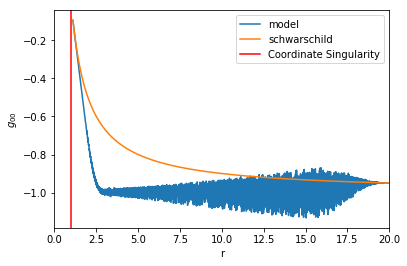

In [41]:
import matplotlib.pyplot as plt
gs = vmap(cartesian_s_metric)(X)
gtt = g[:,0,0]
r = jnp.sqrt((X[:,1:]**2).sum(-1))

r_perm = np.argsort(r)
plt.plot(r[r_perm],gtt[r_perm], label = 'model')
plt.plot(r[r_perm],gs[r_perm,0,0], label = 'schwarschild')
plt.axvline(1,color='r',label='Coordinate Singularity')
plt.xlim(0,20)
plt.ylabel(r"$g_{00}$")
plt.xlabel("r")
plt.legend()
plt.show()

In [42]:
gf = lambda x: net.apply(params,x)
#gf = cartesian_s_metric
M = 100                  
X2 = np.stack(np.meshgrid(np.linspace(-20,20,M),np.linspace(-20,20,M)),axis=-1).reshape(-1,2)
X2 = jnp.concatenate([np.zeros((M*M,1)),X2],axis=-1)
g00_gt = vmap(lambda x: cartesian_s_metric(jnp.concatenate([jnp.array([0.0]),x]))[0,0])
g00 = vmap(lambda x: gf(jnp.concatenate([jnp.array([0.0]),x]))[0,0])
#R2  =vmap(partial(scalar_curvature,lambda x: gf(jnp.concatenate([jnp.array([0.0]),x]))[1:,1:]))(X2)

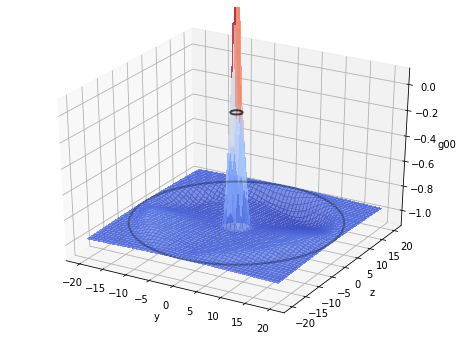

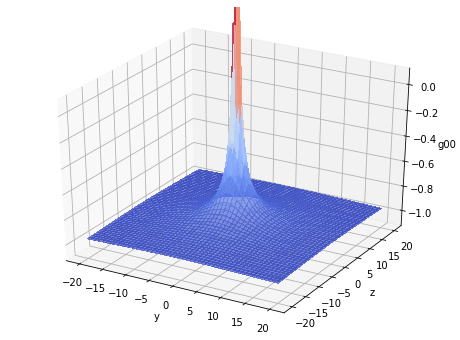

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.set_zlim(-1.1,.1)
surf = ax.plot_surface(*X2.T[1:].reshape(2,M,M), g00(X2).reshape(M,M), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=.7)
theta = np.linspace(0,2*np.pi,M)
rmax = 20
large_X = jnp.stack([np.zeros((M,)),rmax*np.cos(theta),rmax*np.sin(theta)],axis=-1)
ax.plot(*large_X.T[1:],g00(large_X),color='k',lw=2,zorder=100,alpha=.3)
rmin = 1.1
small_X = jnp.stack([np.zeros((M,)),rmin*np.cos(theta),rmin*np.sin(theta)],axis=-1)
ax.plot(*small_X.T[1:],g00(small_X),color='k',lw=2,zorder=101,alpha=.7)
plt.xlabel("y")
plt.ylabel("z")
ax.set_zlabel("g00")
plt.show()
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.set_zlim(-1.1,.1)
surf = ax.plot_surface(*X2.T[1:].reshape(2,M,M), g00_gt(X2).reshape(M,M), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=.7)
plt.xlabel("y")
plt.ylabel("z")
ax.set_zlabel("g00")
plt.show()

In [44]:
g00gtx = g00_gt(X2)
g00x  = g00(X2)

gfunc = partial(net.apply,params)
X2wt = jnp.concatenate([jnp.zeros((X2.shape[0],1)),X2],axis=-1)
gab = vmap(gfunc)(X2wt)
Rab = vmap(partial(ricci_curvature,gfunc))(X2wt)

R = vmap(partial(R,params))(X2wt)

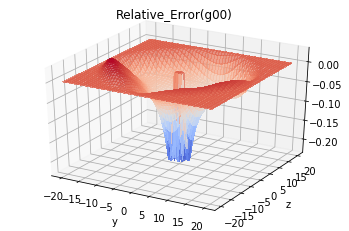

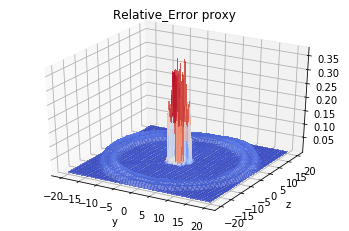

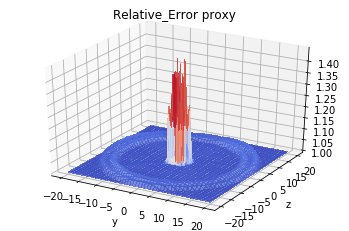

In [48]:


rel_err = (g00x-g00gtx)/(jnp.abs(g00x)+jnp.abs(g00gtx))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(*X2.T[1:].reshape(2,M,M), rel_err.reshape(M,M), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=.7)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Relative_Error(g00)")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')


proxy = jnp.abs(Rab).sum(-1).sum(-1)/jnp.abs(gab).sum(-1).sum(-1)
surf = ax.plot_surface(*X2.T[1:].reshape(2,M,M), proxy.reshape(M,M), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=.7)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Relative_Error proxy")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')


proxy = jnp.abs(Rab).sum(-1).sum(-1)/jnp.abs(gab).sum(-1).sum(-1)
surf = ax.plot_surface(*X2.T[1:].reshape(2,M,M), jnp.exp(proxy.reshape(M,M)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=.7)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Relative_Error proxy")
plt.show()

In [6]:
x = 10*random.normal(key,(4,))
print(cartesian_s_metric(x))

[[-0.8985399   0.          0.          0.        ]
 [ 0.          1.0662384  -0.02982405  0.04692988]
 [ 0.         -0.02982405  1.0134283  -0.0211303 ]
 [ 0.          0.04692988 -0.0211303   1.0332497 ]]


In [7]:
gfunc = cartesian_s_metric

In [31]:
Dg = D(gfunc)(x)

In [32]:
print(gfunc(x))
#print(Dg[1])

[[-0.8946183   0.          0.          0.        ]
 [ 0.          1.0031552  -0.00531161  0.01826223]
 [ 0.         -0.00531161  1.0089415  -0.03074262]
 [ 0.          0.01826223 -0.03074262  1.1056983 ]]


In [33]:
Dg[:,:,1]

DeviceArray([[-0.00181755,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.00389363, -0.00313445,  0.01077678],
             [ 0.        , -0.00313445, -0.00048082,  0.00165314],
             [ 0.        ,  0.01077678,  0.00165314, -0.00568377]],            dtype=float32)

In [34]:
ricci_curvature(gfunc,x)

DeviceArray([[-1.09139364e-10,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  5.87306204e-10,  4.04725142e-11,
              -1.90084393e-10],
             [ 0.00000000e+00, -1.72803993e-11,  5.86624083e-10,
              -7.09405867e-11],
             [ 0.00000000e+00, -1.54614099e-11, -7.09405867e-11,
               1.60071068e-10]], dtype=float32)

In [35]:
scalar_curvature(gfunc,x)

DeviceArray(1.6443664e-09, dtype=float32)

In [36]:
from jax import device_put
X = 10*random.normal(key,(10000,4))
X=X[X[:,1]>1.2]
X = device_put(X)
print(X.shape)

(4451, 4)


In [38]:
x=X[0]
Γ = christoffel_symbols(D(spherical_s_metric)(x),jnp.linalg.inv(spherical_s_metric(x)))
t,r,theta,phi = x
rs=1

In [39]:
print("Γtrt {} vs {}".format(Γ[0,1,0],rs/(2*r*(r-rs))))
print("Γrrr {} vs {}".format(Γ[1,1,1],-rs/(2*r*(r-rs))))
print("Γttr {} vs {}".format(Γ[0,0,1],rs*(r-rs)/(2*r**3)))
print(f"Γφφr {Γ[3,3,1]} vs {(rs-r)*np.sin(theta)**2}")
print(f"Γθθr {Γ[2,2,1]} vs {(rs-r)}")
print(f"Γrθθ {Γ[1,2,2]},  Γrφφ {Γ[1,3,3]} vs {1/r}")
print(f"Γφφθ {Γ[3,3,2]} vs {-np.sin(theta)*np.cos(theta)}")
print(f"Γθφφ {Γ[2,3,3]} vs {np.cos(theta)/np.sin(theta)}")

Γtrt 0.0008695434080436826 vs 0.0008695434021909534
Γrrr -0.0008695434080436826 vs -0.0008695434021909534
Γttr 0.0007999662775546312 vs 0.0007999662760983848
Γφφr -3.0665109157562256 vs -3.0665110338219432
Γθθr -23.484670639038086 vs -23.484670639038086
Γrθθ 0.040841881185770035,  Γrφφ 0.040841881185770035 vs 0.04084188081360634
Γφφθ -0.3369349539279938 vs -0.3369349539279938
Γθφφ 2.5803942680358887 vs 2.5803940296173096


In [42]:
print(x)
print(spherical_s_metric(x))

[-0.03292855 24.48467     0.36971706 -3.512978  ]
[[   0.9591581   -0.          -0.          -0.       ]
 [  -0.          -1.042581    -0.          -0.       ]
 [  -0.          -0.        -599.4991      -0.       ]
 [  -0.          -0.          -0.         -78.279594 ]]


In [43]:
vmap(lambda x: scalar_curvature(gfunc,x))(X)

DeviceArray([ 1.3807622e-10,  6.3830186e-10, -7.6252036e-09, ...,
             -2.5902409e-09,  3.6379788e-10,  1.1641532e-09],            dtype=float32)

In [44]:
R = jit(vmap(lambda x: scalar_curvature(gfunc,x)))
%timeit R(X).block_until_ready()

2.61 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# jgg = vmap(lambda x: scalar_curvature(jit(gfunc),x))
# %timeit jgg(X)

In [27]:
jjg = jit(vmap(lambda x: scalar_curvature(gfunc,x)))
%timeit jjg(X).block_until_ready()

2.51 ms ± 9.01 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
Rab = jit(vmap(lambda x: ricci_curvature(gfunc,x)))
%timeit Rab(X).block_until_ready()

2.17 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
ricci_curvature(gfunc,X[0])

DeviceArray([[-1.2505552e-11,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00],
             [ 0.0000000e+00,  7.9580786e-12, -1.9362290e-13,
               1.0672352e-11],
             [ 0.0000000e+00, -8.7574392e-13,  4.8224064e-11,
               5.1070259e-15],
             [ 0.0000000e+00,  7.0485839e-12,  3.3750780e-14,
               7.9829476e-11]], dtype=float32)

In [30]:
#X[0]

DeviceArray([-0.03292855, 24.48467   ,  0.36971706, -3.512978  ], dtype=float32)

In [1]:
#vmap(lambda x: ricci_curvature(gfunc,x))(X)